In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import random
from sklearn import model_selection, preprocessing, svm, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [79]:
stock_list = ["AC.PA", "AI.PA", "AIR.PA", "ATO.PA", "BNP.PA", "EN.PA", "CAP.PA", "CA.PA", "ACA.PA", 
          "BN.PA", "ENGI.PA", "KER.PA", "OR.PA", "LHN.PA", "LR.PA", "MC.PA", "ML.PA", "ORA.PA",
          "UG.PA", "SGO.PA", "SAN.PA", "SU.PA", "GLE.PA", "SW.PA", "FP.PA", "FR.PA", "VIE.PA", "DG.PA", "VIV.PA"]

In [80]:
class Open_csv:
    
    def __init__(self):
        pass
    
    def open(self,path_to_file):
        data = np.asarray(pd.read_csv(path_to_file, delimiter=",").values)
        return data

In [81]:
def f_1(vector):
    return (vector[2]-vector[3])/(vector[1]+vector[4]) # (high-low)/(open+close)

In [82]:
class Preprocess_data:
    
    def __init__(self):
        self.function = f_1
        self.open_csv = Open_csv()
        self.data = None
        self.returns = []
        self.log_returns = True
        self.depth = 5
        self.X_ = None
        self.X_all = None
        self.y_ = None
        self.y_all = None     
        
    def get_data_stock(self,stock_name):
        self.data = self.open_csv.open("data/"+stock_name+".csv")
    
    def get_stock_return(self):
        for i in range(len(self.data)):
            self.returns.append(self.function(self.data[i]))
        self.returns = np.asarray(self.returns)
        
    def show_distribution_log_returns(self):
        plt.hist(np.log(self.returns),bins=200)
        plt.title("log(returns)")
        plt.show()
        mu = np.mean(np.log(stock_returns[0]))
        sigma = np.std(np.log(stock_returns[0]))
        s = np.random.normal(mu, sigma, 1300)
        plt.hist(s, bins=200, normed=True)
        plt.title("Normal(mean(log(returns)),std(log(returns)))")
        plt.show()
        
    def get_log_returns(self):
        if self.log_returns:
            temp = np.empty(len(np.where(self.returns!=0)[0]))
            for i in range(len(np.where(self.returns!=0)[0])):
                temp[i] = self.returns[np.where(self.returns!=0)[0][i]]
            #self.returns = np.log(temp)
            self.returns = (np.log(temp)-np.mean(np.log(temp)))/np.std(np.log(temp))
            
    def compute_X_and_y(self):
        self.X_ = []
        self.y_ = []
        for i in range(len(self.returns)-self.depth):
            temp = self.returns
            self.y_.append(temp[i])
            self.X_.append(np.array(temp[i+1:i+1+self.depth]))
        self.y_ = np.array(self.y_)        
        temp2 = np.empty((len(self.X_)-1,len(self.X_[0])))
        for i in range(len(temp2)):
            temp2[i] = np.array(self.X_[i])
        self.X_ = temp2
        self.y_ = self.y_[:len(self.X_)]
        
    def focus_on_recent_data(self):
        n_data_for_training = 500
        start_index = 50
        self.X_, self.X_all = self.X_[start_index:start_index+n_data_for_training], self.X_
        self.y_, self.y_all = self.y_[start_index:start_index+n_data_for_training], self.y_
    
    def run(self,stock_name,focus_on_recent_data):
        self.get_data_stock(stock_name)
        self.get_stock_return()
        self.get_log_returns()
        self.compute_X_and_y()
        if focus_on_recent_data:
            self.focus_on_recent_data()
            
    def reset(self):
        self.function = f_1
        self.open_csv = Open_csv()
        self.data = None
        self.returns = []
        self.log_returns = True
        self.depth = 5
        self.X_ = None
        self.X_all = None
        self.y_ = None
        self.y_all = None 

In [83]:
class Estimate:
    
    def __init__(self):
        self.X_ = None
        self.y_ = None
        self.optimize_rf = True
        self.optimize_svm = True
        self.ypred_randomforest = None
        self.ypred_svm = None
    
    def cross_validate(self, design_matrix, labels, regressor, cv_folds):
        pred = np.zeros(labels.shape) # Hold all predictions, in correct order.
        for tr, te in cv_folds:        
            scaler = preprocessing.StandardScaler()
            Xtr = scaler.fit_transform(design_matrix[tr,:])
            ytr = labels[tr]
            Xte = scaler.transform(design_matrix[te,:])
            regressor.fit(Xtr, ytr)
            pred[te] = (regressor.predict(Xte))
        return pred

    def random_forest_estimate(self):
        # Set up a stratified 10-fold cross-validation
        skf = model_selection.KFold(n_splits=10)
        skf.get_n_splits(self.X_, self.y_)
        folds = [(tr,te) for (tr,te) in skf.split(self.X_, self.y_)]
        
        if self.optimize_rf:
            param_grid = {'n_estimators':[1,10],
                    'max_features':[1,4],
                    'max_depth':[1,9]}

            clf_rf = GridSearchCV(RandomForestRegressor(),
                           param_grid)

            self.ypred_randomforest = self.cross_validate(self.X_, self.y_, clf_rf, folds)

        else:
            self.ypred_randomforest = self.cross_validate(self.X_,self.y_,RandomForestRegressor(),folds)
    
    def svm_estimate(self):
        # Set up a stratified 10-fold cross-validation
        skf = model_selection.KFold(n_splits=10)
        skf.get_n_splits(self.X_, self.y_)
        folds = [(tr,te) for (tr,te) in skf.split(self.X_, self.y_)]
        if self.optimize_svm:
            param_grid = {'C':[0.01,10]}

            clf_svm = GridSearchCV(svm.SVR(kernel='linear'),
                           param_grid)

            self.ypred_svm = self.cross_validate(self.X_, self.y_, clf_svm, folds)

        else:
            self.ypred_svm = self.cross_validate(self.X_, self.y_, svm.SVR(kernel='linear'), folds)
            
    def run(self,X_,y_):
        self.X_ = X_
        self.y_ = y_
        self.random_forest_estimate()
        self.svm_estimate()
        
    def reset(self):
        self.X_ = None
        self.y_ = None
        self.optimize_rf = True
        self.optimize_svm = True
        self.ypred_randomforest = None
        self.ypred_svm = None

In [86]:
preprocess_data = Preprocess_data()
estimate = Estimate()

In [76]:
    stock_name = "BNP.PA"
    preprocess_data.run(stock_name,
                   focus_on_recent_data=True)
    estimate.run(preprocess_data.X_,preprocess_data.y_)
    ypred_randomforest = estimate.ypred_randomforest
    ypred_svm = estimate.ypred_svm
    y_ = estimate.y_
    
    print(stock_name)
    
    # comparaison avec différents prédicteurs "stupides"
    y1_ = np.array([np.mean(y_)]*len(y_))
    print("dummy estimator : mean of |y1_ - y_|   :   "+str(np.mean(np.abs(y1_-y_))))
    print("dummy estimator : explained variance : "+str(metrics.explained_variance_score(y_,y1_)))
    print("dummy estimator : mean absolute error : "+str(metrics.mean_absolute_error(y_,y1_)))
    print("dummy estimator : mean squared error : "+str(metrics.mean_squared_error(y_,y1_)))
    print("dummy estimator : r2 score : "+str(metrics.r2_score(y_,y1_)))
    
    # random forest
    print("randomforest : mean of |ypred_randomforest - y_|   :   "+str(np.mean(np.abs(ypred_randomforest-y_))))
    print("randomforest : explained variance : "+str(metrics.explained_variance_score(y_,ypred_randomforest)))
    print("randomforest : mean absolute error : "+str(metrics.mean_absolute_error(y_,ypred_randomforest)))
    print("randomforest : mean squared error : "+str(metrics.mean_squared_error(y_,ypred_randomforest)))
    print("randomforest : r2 score : "+str(metrics.r2_score(y_,ypred_randomforest)))
    
    # svm
    print("svm : mean of |ypred_svm - y_|   :   "+str(np.mean(np.abs(ypred_svm-y_))))
    print("svm : explained variance : "+str(metrics.explained_variance_score(y_,ypred_svm)))
    print("svm : mean absolute error : "+str(metrics.mean_absolute_error(y_,ypred_svm)))
    print("svm : mean squared error : "+str(metrics.mean_squared_error(y_,ypred_svm)))
    print("svm : r2 score : "+str(metrics.r2_score(y_,ypred_svm)))

BNP.PA
dummy estimator : mean of |y1_ - y_|   :   0.8219660848595037
dummy estimator : explained variance : 0.0
dummy estimator : mean absolute error : 0.8219660848595037
dummy estimator : mean squared error : 1.093932817390433
dummy estimator : r2 score : 0.0
randomforest : mean of |ypred_randomforest - y_|   :   0.7608630433237791
randomforest : explained variance : 0.160774126094269
randomforest : mean absolute error : 0.7608630433237791
randomforest : mean squared error : 0.918183196045617
randomforest : r2 score : 0.16065851444521528
svm : mean of |ypred_svm - y_|   :   0.7238446843217716
svm : explained variance : 0.25838601740259237
svm : mean absolute error : 0.7238446843217716
svm : mean squared error : 0.8126985650490076
svm : r2 score : 0.25708548813107845


In [87]:
for stock_name in stock_list:
    preprocess_data.run(stock_name,
                   focus_on_recent_data=True)
    estimate.run(preprocess_data.X_,preprocess_data.y_)
    ypred_randomforest = estimate.ypred_randomforest
    ypred_svm = estimate.ypred_svm
    y_ = estimate.y_
    
    print(stock_name)
    
    # comparaison avec différents prédicteurs "stupides"
    y1_ = np.array([np.mean(y_)]*len(y_))
    print("dummy estimator : mean of |y1_ - y_|   :   "+str(np.mean(np.abs(y1_-y_))))
    print("dummy estimator : explained variance : "+str(metrics.explained_variance_score(y_,y1_)))
    print("dummy estimator : mean absolute error : "+str(metrics.mean_absolute_error(y_,y1_)))
    print("dummy estimator : mean squared error : "+str(metrics.mean_squared_error(y_,y1_)))
    print("dummy estimator : r2 score : "+str(metrics.r2_score(y_,y1_)))
    
    # random forest
    print("randomforest : mean of |ypred_randomforest - y_|   :   "+str(np.mean(np.abs(ypred_randomforest-y_))))
    print("randomforest : explained variance : "+str(metrics.explained_variance_score(y_,ypred_randomforest)))
    print("randomforest : mean absolute error : "+str(metrics.mean_absolute_error(y_,ypred_randomforest)))
    print("randomforest : mean squared error : "+str(metrics.mean_squared_error(y_,ypred_randomforest)))
    print("randomforest : r2 score : "+str(metrics.r2_score(y_,ypred_randomforest)))
    
    # svm
    print("svm : mean of |ypred_svm - y_|   :   "+str(np.mean(np.abs(ypred_svm-y_))))
    print("svm : explained variance : "+str(metrics.explained_variance_score(y_,ypred_svm)))
    print("svm : mean absolute error : "+str(metrics.mean_absolute_error(y_,ypred_svm)))
    print("svm : mean squared error : "+str(metrics.mean_squared_error(y_,ypred_svm)))
    print("svm : r2 score : "+str(metrics.r2_score(y_,ypred_svm)))
    
    preprocess_data.reset()
    estimate.reset()

AC.PA
dummy estimator : mean of |y1_ - y_|   :   0.8172673537749439
dummy estimator : explained variance : -2.220446049250313e-16
dummy estimator : mean absolute error : 0.8172673537749439
dummy estimator : mean squared error : 1.095117342263853
dummy estimator : r2 score : 0.0
randomforest : mean of |ypred_randomforest - y_|   :   0.745772655234306
randomforest : explained variance : 0.14485981025294925
randomforest : mean absolute error : 0.745772655234306
randomforest : mean squared error : 0.937344212302147
randomforest : r2 score : 0.14406961142223662
svm : mean of |ypred_svm - y_|   :   0.6878744172264405
svm : explained variance : 0.2875568215873373
svm : mean absolute error : 0.6878744172264405
svm : mean squared error : 0.7853725084437752
svm : r2 score : 0.2828416845082242
AI.PA
dummy estimator : mean of |y1_ - y_|   :   0.7731121424290449
dummy estimator : explained variance : 0.0
dummy estimator : mean absolute error : 0.7731121424290449
dummy estimator : mean squared error

KER.PA
dummy estimator : mean of |y1_ - y_|   :   0.749783424852274
dummy estimator : explained variance : 0.0
dummy estimator : mean absolute error : 0.749783424852274
dummy estimator : mean squared error : 0.8853662890359112
dummy estimator : r2 score : 0.0
randomforest : mean of |ypred_randomforest - y_|   :   0.746898360236014
randomforest : explained variance : 0.010390860904763488
randomforest : mean absolute error : 0.746898360236014
randomforest : mean squared error : 0.8761867016556171
randomforest : r2 score : 0.010368123898516601
svm : mean of |ypred_svm - y_|   :   0.7379034545259227
svm : explained variance : 0.05197866243162097
svm : mean absolute error : 0.7379034545259227
svm : mean squared error : 0.841600772048316
svm : r2 score : 0.04943210231694295
OR.PA
dummy estimator : mean of |y1_ - y_|   :   0.742474646761017
dummy estimator : explained variance : 0.0
dummy estimator : mean absolute error : 0.742474646761017
dummy estimator : mean squared error : 0.930132177904

GLE.PA
dummy estimator : mean of |y1_ - y_|   :   0.8184384487991634
dummy estimator : explained variance : 0.0
dummy estimator : mean absolute error : 0.8184384487991634
dummy estimator : mean squared error : 1.1186526285941394
dummy estimator : r2 score : 0.0
randomforest : mean of |ypred_randomforest - y_|   :   0.7418280653250671
randomforest : explained variance : 0.16060084523027118
randomforest : mean absolute error : 0.7418280653250671
randomforest : mean squared error : 0.9397607556775528
randomforest : r2 score : 0.15991726863540112
svm : mean of |ypred_svm - y_|   :   0.7075107144070085
svm : explained variance : 0.27754519482665263
svm : mean absolute error : 0.7075107144070085
svm : mean squared error : 0.809394699468988
svm : r2 score : 0.2764557300632364
SW.PA
dummy estimator : mean of |y1_ - y_|   :   0.7703839089440626
dummy estimator : explained variance : 0.0
dummy estimator : mean absolute error : 0.7703839089440626
dummy estimator : mean squared error : 1.038648848

In [88]:
explained_variance_randomforest = []
explained_variance_svm = []
stock_names = []

for stock_name in stock_list:
    preprocess_data.run(stock_name,
                   focus_on_recent_data=True)
    estimate.run(preprocess_data.X_,preprocess_data.y_)
    ypred_randomforest = estimate.ypred_randomforest
    ypred_svm = estimate.ypred_svm
    y_ = estimate.y_
    
    # random forest    
    explained_variance_randomforest.append(metrics.explained_variance_score(y_,ypred_randomforest))
    
    # svm    
    explained_variance_svm.append(metrics.explained_variance_score(y_,ypred_svm))
    
    # stock_name
    print(stock_name)
    stock_names.append(stock_name)
    
    preprocess_data.reset()
    estimate.reset()

AC.PA
AI.PA
AIR.PA
ATO.PA
BNP.PA
EN.PA
CAP.PA
CA.PA
ACA.PA
BN.PA
ENGI.PA
KER.PA
OR.PA
LHN.PA
LR.PA
MC.PA
ML.PA
ORA.PA
UG.PA
SGO.PA
SAN.PA
SU.PA
GLE.PA
SW.PA
FP.PA
FR.PA
VIE.PA
DG.PA
VIV.PA


In [89]:
def sort_by_x(x,y,z):
    index = 0
    while index < len(x):
        for i in range(index,len(x)):
            if x[i]<x[index]:
                z[i],z[index],y[i],y[index],x[i],x[index]=z[index],z[i],y[index],y[i],x[index],x[i]
        index+=1

In [90]:
sort_by_x(explained_variance_svm,explained_variance_randomforest,stock_names)

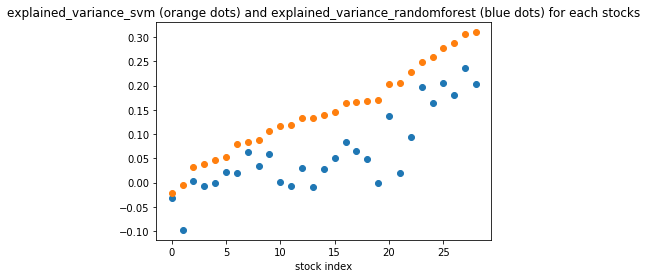

from 0 to  last : ['ENGI.PA', 'CA.PA', 'BN.PA', 'VIV.PA', 'ML.PA', 'KER.PA', 'CAP.PA', 'SAN.PA', 'SW.PA', 'AI.PA', 'MC.PA', 'VIE.PA', 'AIR.PA', 'LR.PA', 'DG.PA', 'OR.PA', 'ATO.PA', 'SGO.PA', 'EN.PA', 'SU.PA', 'FR.PA', 'ORA.PA', 'UG.PA', 'ACA.PA', 'BNP.PA', 'GLE.PA', 'AC.PA', 'LHN.PA', 'FP.PA']


In [96]:
plt.plot(explained_variance_randomforest,'o')
plt.plot(explained_variance_svm,'o')
plt.title("explained_variance_svm (orange dots) and explained_variance_randomforest (blue dots) for each stocks")
plt.xlabel("stock index")
plt.show()
print("from 0 to  last : "+str(stock_names))